## Accessing Sentinel-2 L2A data with the Planetary Computer STAC API

### Environment setup

In [35]:
from pystac_client import API
import planetary_computer as pc

# If you have a Planetary Computer API key, specify it here. This notebook
# will work with or without an API key, but you will be given more permissive
# access to data with an API key.
subscription_key = None
pc.settings.set_subscription_key(subscription_key)

### Choose a region and time of interest

This area is near Jonah Bay, Alaska.

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-148.56536865234375,60.80072385643073],
            [-147.44338989257812,60.80072385643073],
            [-147.44338989257812,61.18363894915102],
            [-148.56536865234375,61.18363894915102],
            [-148.56536865234375,60.80072385643073]
        ]
    ],
}

Define the time range to filter images with. Here we use the summer of 2019.

In [3]:
time_of_interest = "2019-06-01/2019-08-01"

### Search the collection and choose an image to render

Use [pystac_client](https://github.com/stac-utils/pystac-client) to search for Sentinel 2 L2A data in June of 2020.

In [5]:
api = API.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = api.search(
    collections=['sentinel-2-l2a'], 
    intersects=area_of_interest, 
    datetime=time_of_interest    
)
print(f"{search.matched()} Items found")

85 Items found


We can now work directly with the [PySTAC](https://github.com/stac-utils/pystac) Items returned by the API. Here we find the least cloudy of the bunch.

In [6]:
least_cloudy_item = sorted(search.items(), key=lambda item: item.ext.eo.cloud_cover)[0]

Get the URL to the 20m resolution visual [Cloud Optimized GeoTIFF](https://www.cogeo.org/) image.

In [7]:
asset_href = least_cloudy_item.assets['visual-20m'].href

This HREF is a URL is the location of the asset data on [Azure Blob Storage](https://azure.microsoft.com/en-us/services/storage/blobs/). In order to read the data, we'll need to retrieve a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) and supply it as a query parameter. These tokens are generated from the Planetary Computer [Data Access API](https://planetarycomputer.microsoft.com/api/sas/v1/docs).

We use the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package to "sign" our asset HREF with a generated token:

In [8]:
signed_href = pc.sign(asset_href)

We can now use the HREF to read our data in any tools that can retrieve data from URLs via HTTP GET operations.

For example, here we use rasterio to render the image data over our area of interest:

### Render our AOI from this image

In [14]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

In [20]:
with rasterio.open(signed_href) as ds:    
    warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

rasterio gives us data band-interleave format; transpose to pixel interleave, and downscale the image data for plotting.

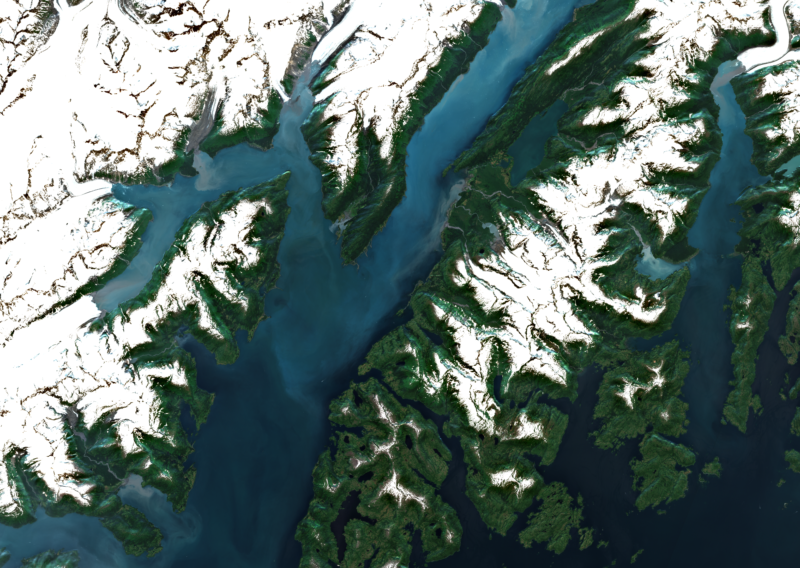

In [34]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]; h = img.size[1]; aspect = w/h
target_w = 800; target_h = (int)(target_w/aspect)
img.resize((target_w,target_h),Image.BILINEAR)